In [116]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import scipy.stats as st
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from metpy.cbook import get_test_data

In [117]:
def get_dt():
    dt_stamp = dt.datetime.now()
    dt_stamp = dt_stamp.strftime("%Y_%m_%d_%H%M%S")
    dt_stamp = str(dt_stamp).split(".")[0]
    return dt_stamp

In [118]:
# Define a function to create Linear Regression plots
def lin_reg(x, y):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), 'r')

In [203]:
csv_data = pd.read_csv('C:/C_Drive/Bootcamp/Homework/Project-One-1/U.S._Chronic_Disease_Indicators__Cancer_Final.csv')


In [206]:
indexes = ['Idaho', 'Illinois', 'Kansas', 'Massachusetts', 'Montana', 'North Dakota', 'South Dakota', 'Vermont', 'Washington, D.C.', 'Wyoming', 'District of Columbia', 'Maine', 'West Virginia']

In [207]:
csv_data['flag'] = csv_data.loc[(csv_data['LocationDesc'] == 'Idaho')
                                | (csv_data['LocationDesc'] == 'Illinois')
                                | (csv_data['LocationDesc'] == 'Kansas')
                                | (csv_data['LocationDesc'] == 'Massachusetts')
                                | (csv_data['LocationDesc'] == 'Montana')
                                | (csv_data['LocationDesc'] == 'North Dakota')
                                | (csv_data['LocationDesc'] == 'South Dakota')
                                | (csv_data['LocationDesc'] == 'Vermont')
                                | (csv_data['LocationDesc'] == 'Washington, D.C.')
                                | (csv_data['LocationDesc'] == 'Wyoming')
                                | (csv_data['LocationDesc'] == 'District of Columbia')
                                | (csv_data['LocationDesc'] == 'Maine')
                                | (csv_data['LocationDesc'] == 'West Virginia')
                                , 'LocationAbbr']

In [208]:
csv_data = csv_data.loc[csv_data['flag'].isna()]

In [214]:
csv_data.drop('flag',axis=1, inplace=True)

In [215]:
csv_data.head()

,Year,LocationAbbr,LocationDesc,Topic,Question,DataValueType,DataValue,StratificationCategory1,Stratification1
0,2014,AK,Alaska,Breast Cancer,incidence,Average Annual Number,11,Race,Hispanic
1,2018,AK,Alaska,Breast Cancer,incidence,Average Annual Number,435,Gender,Female
2,2013,AL,Alabama,Breast Cancer,incidence,Average Annual Number,23,Race,Hispanic
3,2014,AL,Alabama,Breast Cancer,incidence,Average Annual Number,3579,Gender,Female
4,2017,AL,Alabama,Breast Cancer,incidence,Average Annual Number,31,Race,Hispanic


In [216]:
emp_data = pd.read_csv('C:/C_Drive/Bootcamp/ProjectData/Unemployment_2015_2019_final.csv')

In [217]:
income_data = pd.read_csv('C:/C_Drive/Bootcamp/ProjectData/median_house_income.csv')

In [218]:
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   State             260 non-null    object
 1   Year              260 non-null    int64 
 2   Household_Income  260 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 6.2+ KB


In [219]:
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3120 entries, 0 to 3768
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Year                     3120 non-null   int64 
 1   LocationAbbr             3120 non-null   object
 2   LocationDesc             3120 non-null   object
 3   Topic                    3120 non-null   object
 4   Question                 3120 non-null   object
 5   DataValueType            3120 non-null   object
 6   DataValue                3120 non-null   int64 
 7   StratificationCategory1  3120 non-null   object
 8   Stratification1          3120 non-null   object
dtypes: int64(2), object(7)
memory usage: 308.3+ KB


In [220]:
csv_data.groupby('Topic', as_index=False)['Topic'].first()

,Topic
0,Breast Cancer


In [221]:
csv_data.groupby('Question', as_index=False)['Question'].first()

,Question
0,incidence
1,mortality


In [222]:
csv_data.groupby('StratificationCategory1', as_index=False)['StratificationCategory1'].first()

,StratificationCategory1
0,Gender
1,Overall
2,Race


In [223]:
csv_data.groupby('Stratification1', as_index=False)['Stratification1'].first()

,Stratification1
0,Black
1,Female
2,Hispanic
3,Overall
4,White


In [224]:
df = csv_data.loc[(csv_data['Question'] == 'incidence')
                   & (csv_data['StratificationCategory1'] == 'Race')
                   & (csv_data['Year'] >= 2015)
                    & (csv_data['DataValueType'] == 'Average Annual Number')
                    & ((csv_data['Stratification1'] == 'Black')
                    | (csv_data['Stratification1'] == 'Hispanic')
                    | (csv_data['Stratification1'] == 'White'))].copy()
df1 = df.groupby(['Question', 'Year', 'Stratification1'], as_index=False)['DataValue'].mean()
df2 = df1
df2.head()

,Question,Year,Stratification1,DataValue
0,incidence,2015,Black,1294.500
1,incidence,2015,Hispanic,915.850
2,incidence,2015,White,8444.500
3,incidence,2016,Black,1326.800
4,incidence,2016,Hispanic,960.175


In [225]:
df2.rename(columns={'LocationDesc': 'State', 'Stratification1': 'Race', 'DataValue': 'insidents'}, inplace=True)

In [226]:
df2.head()

,Question,Year,Race,insidents
0,incidence,2015,Black,1294.500
1,incidence,2015,Hispanic,915.850
2,incidence,2015,White,8444.500
3,incidence,2016,Black,1326.800
4,incidence,2016,Hispanic,960.175


In [227]:
df3 = df2.groupby('Race', as_index=False)['Race'].first()
df3.head()


,Race
0,Black
1,Hispanic
2,White


In [228]:
df2_gb = df2.groupby(['Year', 'Race'], as_index=False)['insidents'].sum()
df2_gb.sort_values(['Year', 'insidents'], ascending=[True, False])
df2_gb.head()

,Year,Race,insidents
0,2015,Black,1294.500
1,2015,Hispanic,915.850
2,2015,White,8444.500
3,2016,Black,1326.800
4,2016,Hispanic,960.175


In [229]:
df_summ = df2_gb.groupby(['Year', 'Race'])['insidents'].sum().unstack().fillna(0)
df_summ = df_summ[['White', 'Black', 'Hispanic']]
df_summ

Race,White,Black,Hispanic
Year,,,
2015,8444.500,1294.500,915.850
2016,8558.725,1326.800,960.175
2017,8674.600,1358.175,1008.075
2018,8775.375,1380.650,1050.200
2019,8876.000,1407.525,1101.350


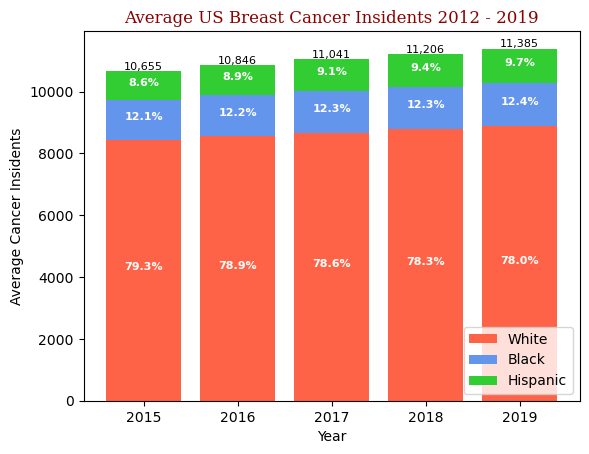

In [230]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig, ax = plt.subplots()

colors = ['tomato', 'cornflowerblue', 'limegreen']
bottom = np.zeros(len(df_summ))

for i, col in enumerate(df_summ.columns):
    ax.bar(df_summ.index, df_summ[col], bottom=bottom, label=col, color=colors[i])
    bottom += np.array(df_summ[col])

totals = df_summ.sum(axis=1)
y_offset = 50

for i, total in enumerate(totals):
    ax.text(totals.index[i], total + y_offset, f'{round(total):,.0f}', ha='center', size=8)

# Add percentages as labels
for idx in df_summ.index:
    start = 0
    for col in df_summ.columns:
        y = df_summ.loc[idx, col]
        value = df_summ.loc[idx, col]
        total = df_summ.loc[idx, :].sum()
        ax.text(
            x=idx,
            y=start + y / 2,
            s=f"{round(100 * value / total, 1)}%",
            fontsize=8,
            weight='bold',
            ha="center",
            color="w",
        )
        start += y

ax.set_title('Average US Breast Cancer Insidents 2012 - 2019', fontdict=font)
ax.set_xlabel('Year')
ax.set_ylabel('Average Cancer Insidents')
ax.legend(loc='lower right')
plt.show()

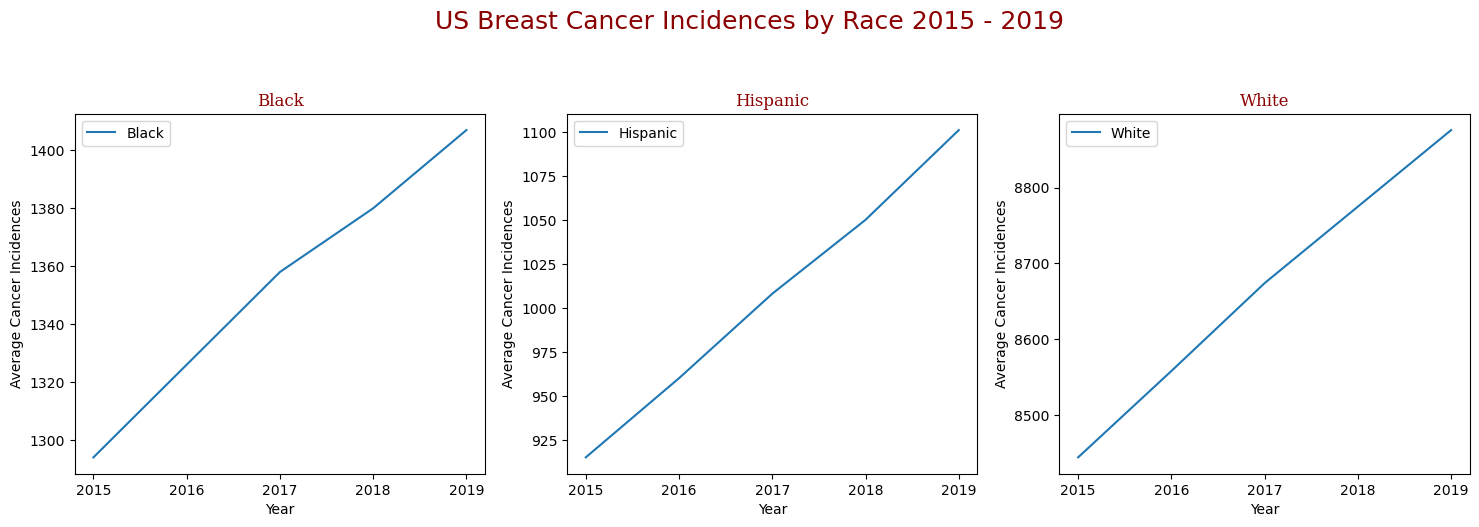

In [231]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(18,8))
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=18, ha='center', color='darkred')

for n, race in df3.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df2_gb.loc[(df2_gb['Race'] == race[0]), 'Year'].values.astype(str)
    y = df2_gb.loc[(df2_gb['Race'] == race[0]), 'insidents'].values.astype(int)
    ax.plot(x, y, label=race[0])
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Cancer Incidences')
    ax.legend()
    ax.set_title(f'{race[0]}', fontdict=font)
    # ax.xaxis.set_tick_params(width=5)
    # ax.yaxis.set_tick_params(width=5)
    # fig.tight_layout()

In [232]:
df_s = csv_data.loc[(csv_data['StratificationCategory1'] == 'Race')
                   & (csv_data['Year'] >= 2015)
                    & (csv_data['DataValueType'] == 'Average Annual Number')
                    & ((csv_data['Stratification1'] == 'Black')
                    | (csv_data['Stratification1'] == 'Hispanic')
                    | (csv_data['Stratification1'] == 'White'))].copy()
df_s.rename(columns={'LocationDesc': 'State', 'Stratification1': 'Race'}, inplace=True)
df_s_gb = df_s.groupby(['Year', 'State', 'Question', 'Race'], as_index=False)['DataValue'].mean()

df_s_gb.head()

,Year,State,Question,Race,DataValue
0,2015,Alabama,incidence,Black,886.0
1,2015,Alabama,incidence,Hispanic,30.0
2,2015,Alabama,incidence,White,2689.0
3,2015,Alabama,mortality,Black,200.0
4,2015,Alabama,mortality,White,472.0


In [233]:
# df_s_summ = df_s_gb.groupby(['Year', 'State', 'Race', 'Question'])['DataValue'].sum().unstack().fillna(0)
df_s_gb['incidence'] = df_s_gb.loc[df_s_gb['Question'] == 'incidence', 'DataValue']
df_s_gb['mortality'] = df_s_gb.loc[df_s_gb['Question'] == 'mortality', 'DataValue']
df_s_gb2 = df_s_gb.groupby(['Year', 'State', 'Race'], as_index=False).agg({'incidence': 'sum', 'mortality': 'sum'})
df_s_gb2.head()

,Year,State,Race,incidence,mortality
0,2015,Alabama,Black,886.0,200.0
1,2015,Alabama,Hispanic,30.0,0.0
2,2015,Alabama,White,2689.0,472.0
3,2015,Alaska,Black,12.0,0.0
4,2015,Alaska,Hispanic,13.0,0.0


In [234]:
emp_data.rename(columns={'state': 'State'}, inplace=True)

In [235]:
emp_data.head()

,State,Year,total_population,unemployed_rate
0,Alabama,2015,3807670,6.1
1,Alabama,2016,3825968,5.7
2,Alabama,2017,3900414,4.0
3,Alabama,2018,3923367,3.8
4,Alabama,2019,3948677,3.1


In [246]:
df_s_merge = pd.merge(df_s_gb2, emp_data, on=['State', 'Year'], how='left')

In [247]:
df_s_merge2 = pd.merge(df_s_merge, income_data, on=['State', 'Year'], how='left')

In [248]:
df_s_merge2.head()

,Year,State,Race,incidence,mortality,total_population,unemployed_rate,Household_Income
0,2015,Alabama,Black,886.0,200.0,3807670.0,6.1,44765
1,2015,Alabama,Hispanic,30.0,0.0,3807670.0,6.1,44765
2,2015,Alabama,White,2689.0,472.0,3807670.0,6.1,44765
3,2015,Alaska,Black,12.0,0.0,544288.0,6.4,73355
4,2015,Alaska,Hispanic,13.0,0.0,544288.0,6.4,73355


In [254]:
# df_s_merge2.loc[df_s_merge2['Household_Income'].isna()]
# df_s_merge2.loc[df_s_merge2['unemployed_rate'].isna()]


,Year,State,Race,incidence,mortality,total_population,unemployed_rate,Household_Income


In [255]:
df_s_merge2 = df_s_merge2.loc[(~df_s_merge2['unemployed_rate'].isna())].copy()

In [256]:
df_s_merge2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585 entries, 0 to 599
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              585 non-null    int64  
 1   State             585 non-null    object 
 2   Race              585 non-null    object 
 3   incidence         585 non-null    float64
 4   mortality         585 non-null    float64
 5   total_population  585 non-null    float64
 6   unemployed_rate   585 non-null    float64
 7   Household_Income  585 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 41.1+ KB


In [270]:
df_s_merge2.loc[df_s_merge2['Household_Income'].isna()]

,Year,State,Race,incidence,mortality,total_population,unemployed_rate,Household_Income


In [1]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure()
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
# fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

# for n, race in df3.iterrows():
ax = fig.add_subplot()
x = df_s_merge2['unemployed_rate']
y = df_s_merge2['incidence']
ax.scatter(x, y)
lin_reg(np.array(df_s_merge2['unemployed_rate']), np.array(df_s_merge2['incidence']))
r, p = st.pearsonr(np.array(df_s_merge2['unemployed_rate']), np.array(df_s_merge2['incidence']))
z = np.polyfit(np.array(df_s_merge2['unemployed_rate']), np.array(df_s_merge2['incidence']), 1)
ax.set_title(f'US Breast Cancer Incidences by Unemployment Rate \n (slope: {z[0]:.1f}, r = {r:.3f})', fontdict=font)
ax.set_xlabel('Unemployment Rate')
ax.set_ylabel('Average Cancer Incidences')
ax.legend()
# ax.set_title(f'TBD', fontdict=font)
# ax.xaxis.set_tick_params(width=5)
# ax.yaxis.set_tick_params(width=5)
fig.tight_layout()
plt.show()

NameError: name 'plt' is not defined

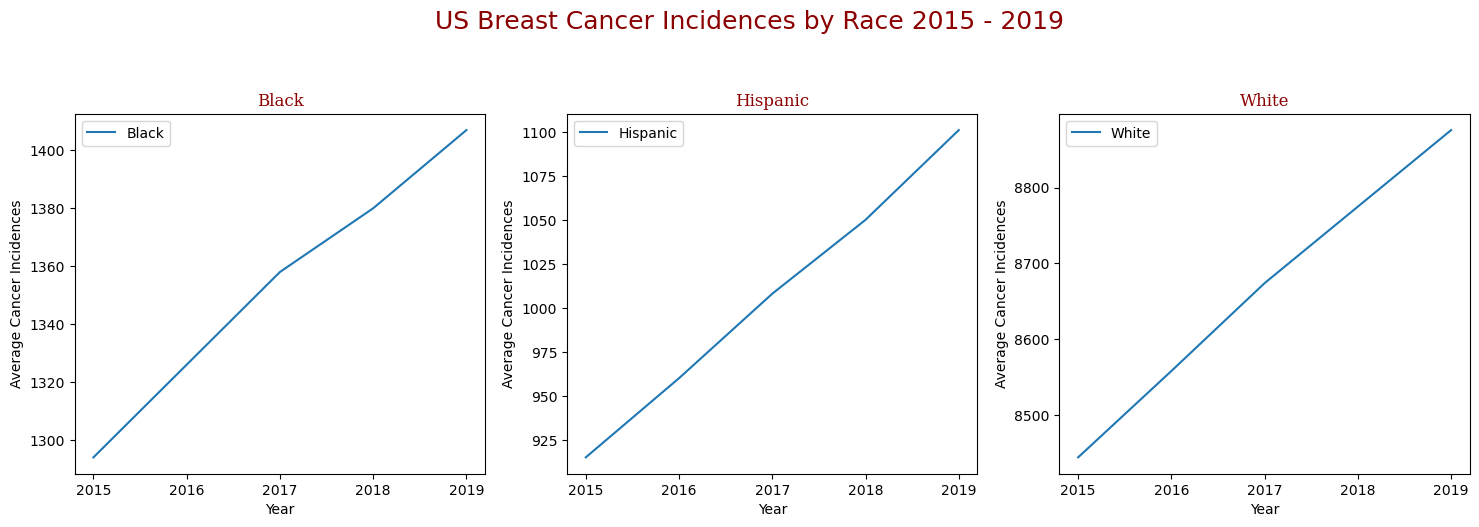

In [272]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(18,8))
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=18, ha='center', color='darkred')

for n, race in df3.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df2_gb.loc[(df2_gb['Race'] == race[0]), 'Year'].values.astype(str)
    y = df2_gb.loc[(df2_gb['Race'] == race[0]), 'insidents'].values.astype(int)
    ax.plot(x, y, label=race[0])
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Cancer Incidences')
    ax.legend()
    ax.set_title(f'{race[0]}', fontdict=font)
    # ax.xaxis.set_tick_params(width=5)
    # ax.yaxis.set_tick_params(width=5)
    # fig.tight_layout()

In [276]:
race_gb = df_s_merge2.groupby('Race', as_index=False)['Race'].first()
race_gb

,Race
0,Black
1,Hispanic
2,White


In [277]:
for n, race in race_gb.iterrows():
    x = df_s_merge2.loc[df_s_merge2['Race'] == race, 'unemployed_rate']
    y = df_s_merge2.loc[df_s_merge2['Race'] == race, 'incidence']
    print(f'n: {n} race: {race}')
    print(f'x: {x} y: {y}')

ValueError: Can only compare identically-labeled Series objects

n: 0 race: Race    Black
Name: 0, dtype: object


ValueError: Can only compare identically-labeled Series objects

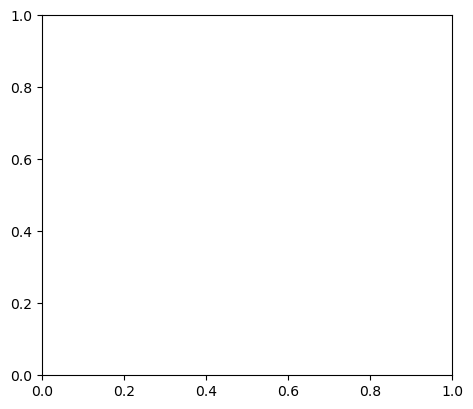

In [278]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(18,8))
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
# fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

for n, race in df3.iterrows():
        print(f'n: {n} race: {race}')
        ax = fig.add_subplot(1, 3, n + 1)
        x = df_s_merge2.loc[df_s_merge2['Race'] == race, 'unemployed_rate']
        y = df_s_merge2.loc[df_s_merge2['Race'] == race, 'incidence']
        ax.scatter(x, y)
        lin_reg(np.array(df_s_merge2.loc[df_s_merge2['Race'] == race, 'unemployed_rate']),
                np.array(df_s_merge2.loc[df_s_merge2['Race'] == race, 'incidence']))
        r, p = st.pearsonr(np.array(df_s_merge2.loc[df_s_merge2['Race'] == race, 'unemployed_rate']),
                np.array(df_s_merge2.loc[df_s_merge2['Race'] == race, 'incidence']))
        z = np.polyfit(np.array(df_s_merge2.loc[df_s_merge2['Race'] == race, 'unemployed_rate']),
                np.array(df_s_merge2.loc[df_s_merge2['Race'] == race, 'incidence']), 1)
        ax.set_title(f'{race} US Breast Cancer Incidences by Unemployment Rate \n (slope: {z:.1f}, r = {r:.1f})', fontdict=font)
        ax.set_xlabel('Unemployment Rate')
        ax.set_ylabel('Average Cancer Incidences')
        # ax.legend()
        # ax.set_title(f'TBD', fontdict=font)
        # ax.xaxis.set_tick_params(width=5)
        # ax.yaxis.set_tick_params(width=5)
        fig.tight_layout()
        plt.show()
        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


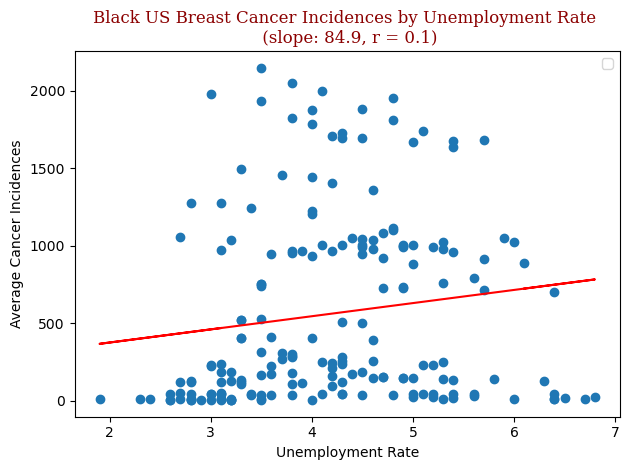

In [54]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure()
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
# fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

# for n, race in df3.iterrows():
ax = fig.add_subplot()
x = df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'unemployed_rate']
y = df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'incidence']
ax.scatter(x, y)
lin_reg(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'unemployed_rate']),
         np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'incidence']))
r, p = st.pearsonr(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'unemployed_rate']),
                    np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'incidence']))
z = np.polyfit(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'unemployed_rate']),
                np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'incidence']), 1)
ax.set_title(f'Black US Breast Cancer Incidences by Unemployment Rate \n (slope: {z[0]:.1f}, r = {r:.1f})', fontdict=font)
ax.set_xlabel('Unemployment Rate')
ax.set_ylabel('Average Cancer Incidences')
ax.legend()
# ax.set_title(f'TBD', fontdict=font)
# ax.xaxis.set_tick_params(width=5)
# ax.yaxis.set_tick_params(width=5)
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


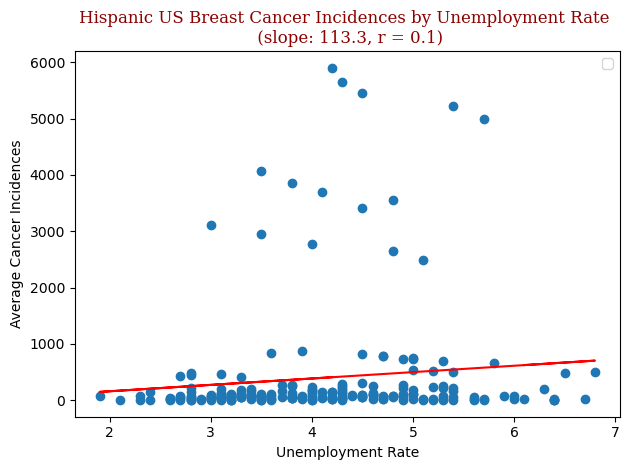

In [55]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure()
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
# fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

# for n, race in df3.iterrows():
ax = fig.add_subplot()
x = df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'unemployed_rate']
y = df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'incidence']
ax.scatter(x, y)
lin_reg(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'unemployed_rate']),
         np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'incidence']))
r, p = st.pearsonr(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'unemployed_rate']),
                    np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'incidence']))
z = np.polyfit(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'unemployed_rate']),
                np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'incidence']), 1)
ax.set_title(f'Hispanic US Breast Cancer Incidences by Unemployment Rate \n (slope: {z[0]:.1f}, r = {r:.1f})', fontdict=font)
ax.set_xlabel('Unemployment Rate')
ax.set_ylabel('Average Cancer Incidences')
ax.legend()
# ax.set_title(f'TBD', fontdict=font)
# ax.xaxis.set_tick_params(width=5)
# ax.yaxis.set_tick_params(width=5)
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


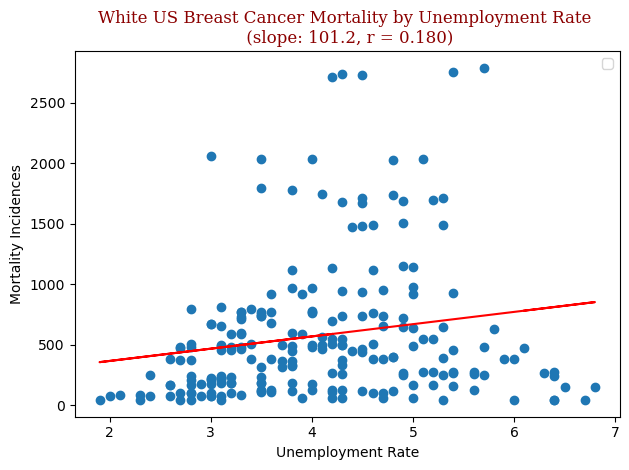

In [56]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure()
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
# fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

# for n, race in df3.iterrows():
ax = fig.add_subplot()
x = df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'unemployed_rate']
y = df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'mortality']
ax.scatter(x, y)
lin_reg(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'unemployed_rate']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'mortality']))
r, p = st.pearsonr(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'unemployed_rate']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'mortality']))
z = np.polyfit(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'unemployed_rate']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'mortality']), 1)
ax.set_title(f'White US Breast Cancer Mortality by Unemployment Rate \n (slope: {z[0]:.1f}, r = {r:.3f})', fontdict=font)
ax.set_xlabel('Unemployment Rate')
ax.set_ylabel('Mortality Incidences')
ax.legend()
# ax.set_title(f'TBD', fontdict=font)
# ax.xaxis.set_tick_params(width=5)
# ax.yaxis.set_tick_params(width=5)
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


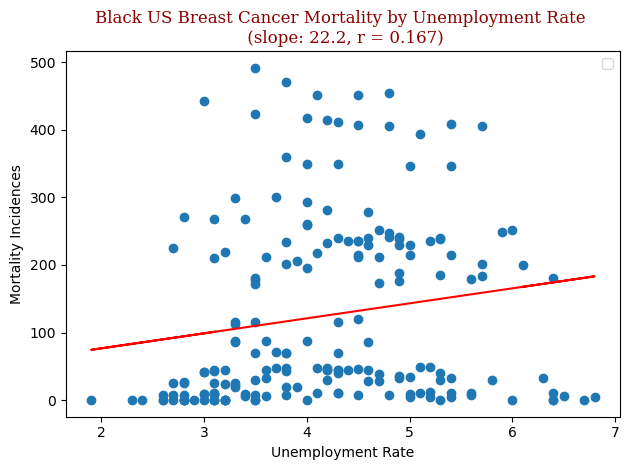

In [57]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure()
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
# fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

# for n, race in df3.iterrows():
ax = fig.add_subplot()
x = df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'unemployed_rate']
y = df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'mortality']
ax.scatter(x, y)
lin_reg(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'unemployed_rate']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'mortality']))
r, p = st.pearsonr(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'unemployed_rate']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'mortality']))
z = np.polyfit(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'unemployed_rate']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'mortality']), 1)
ax.set_title(f'Black US Breast Cancer Mortality by Unemployment Rate \n (slope: {z[0]:.1f}, r = {r:.3f})', fontdict=font)
ax.set_xlabel('Unemployment Rate')
ax.set_ylabel('Mortality Incidences')
ax.legend()
# ax.set_title(f'TBD', fontdict=font)
# ax.xaxis.set_tick_params(width=5)
# ax.yaxis.set_tick_params(width=5)
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


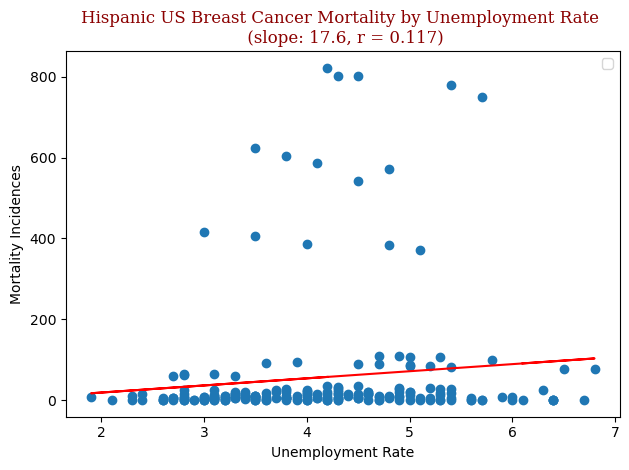

In [58]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure()
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
# fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

# for n, race in df3.iterrows():
ax = fig.add_subplot()
x = df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'unemployed_rate']
y = df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'mortality']
ax.scatter(x, y)
lin_reg(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'unemployed_rate']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'mortality']))
r, p = st.pearsonr(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'unemployed_rate']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'mortality']))
z = np.polyfit(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'unemployed_rate']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'mortality']), 1)
ax.set_title(f'Hispanic US Breast Cancer Mortality by Unemployment Rate \n (slope: {z[0]:.1f}, r = {r:.3f})', fontdict=font)
ax.set_xlabel('Unemployment Rate')
ax.set_ylabel('Mortality Incidences')
ax.legend()
# ax.set_title(f'TBD', fontdict=font)
# ax.xaxis.set_tick_params(width=5)
# ax.yaxis.set_tick_params(width=5)
fig.tight_layout()
plt.show()

In [59]:
df_s_merge2.head()

,Year,State,Race,incidence,mortality,total_population,unemployed_rate,Household_Income
0,2015,Alabama,Black,886.0,200.0,3807670.0,6.1,44765.0
1,2015,Alabama,Hispanic,30.0,0.0,3807670.0,6.1,44765.0
2,2015,Alabama,White,2689.0,472.0,3807670.0,6.1,44765.0
3,2015,Alaska,Black,12.0,0.0,544288.0,6.4,73355.0
4,2015,Alaska,Hispanic,13.0,0.0,544288.0,6.4,73355.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


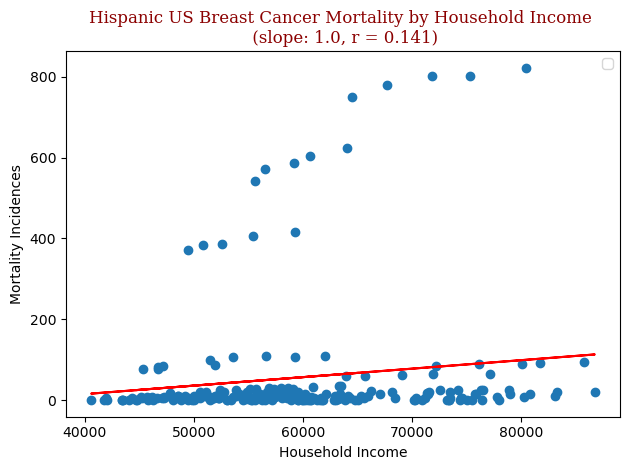

In [62]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure()
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
# fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

# for n, race in df3.iterrows():
ax = fig.add_subplot()
x = df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'Household_Income']
y = df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'mortality']
ax.scatter(x, y)
lin_reg(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'Household_Income']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'mortality']))
r, p = st.pearsonr(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'Household_Income']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'mortality']))
z = np.polyfit(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'Household_Income']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Hispanic', 'Household_Income']), 1)
ax.set_title(f'Hispanic US Breast Cancer Mortality by Household Income \n (slope: {z[0]:.1f}, r = {r:.3f})', fontdict=font)
ax.set_xlabel('Household Income')
ax.set_ylabel('Mortality Incidences')
ax.legend()
# ax.set_title(f'TBD', fontdict=font)
# ax.xaxis.set_tick_params(width=5)
# ax.yaxis.set_tick_params(width=5)
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


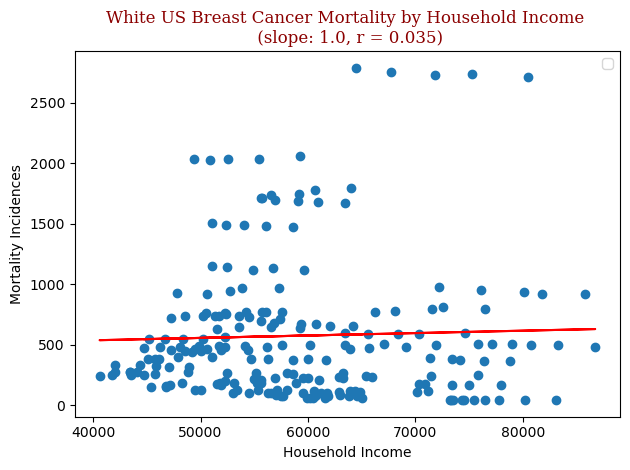

In [64]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure()
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
# fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

# for n, race in df3.iterrows():
ax = fig.add_subplot()
x = df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'Household_Income']
y = df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'mortality']
ax.scatter(x, y)
lin_reg(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'Household_Income']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'mortality']))
r, p = st.pearsonr(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'Household_Income']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'mortality']))
z = np.polyfit(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'Household_Income']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'White', 'Household_Income']), 1)
ax.set_title(f'White US Breast Cancer Mortality by Household Income \n (slope: {z[0]:.1f}, r = {r:.3f})', fontdict=font)
ax.set_xlabel('Household Income')
ax.set_ylabel('Mortality Incidences')
ax.legend()
# ax.set_title(f'TBD', fontdict=font)
# ax.xaxis.set_tick_params(width=5)
# ax.yaxis.set_tick_params(width=5)
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


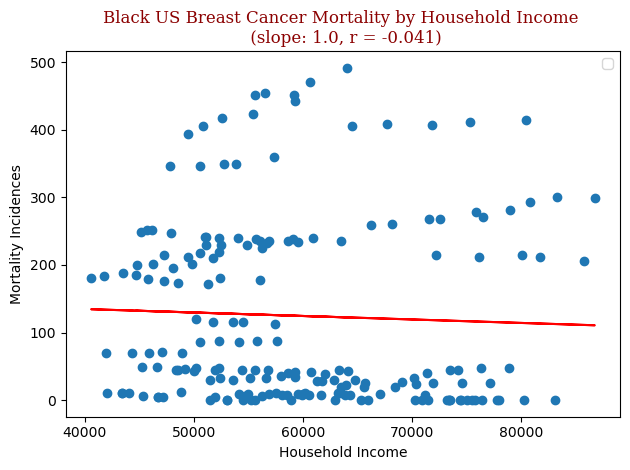

In [65]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure()
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
# fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

# for n, race in df3.iterrows():
ax = fig.add_subplot()
x = df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'Household_Income']
y = df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'mortality']
ax.scatter(x, y)
lin_reg(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'Household_Income']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'mortality']))
r, p = st.pearsonr(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'Household_Income']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'mortality']))
z = np.polyfit(np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'Household_Income']),
        np.array(df_s_merge2.loc[df_s_merge2['Race'] == 'Black', 'Household_Income']), 1)
ax.set_title(f'Black US Breast Cancer Mortality by Household Income \n (slope: {z[0]:.1f}, r = {r:.3f})', fontdict=font)
ax.set_xlabel('Household Income')
ax.set_ylabel('Mortality Incidences')
ax.legend()
# ax.set_title(f'TBD', fontdict=font)
# ax.xaxis.set_tick_params(width=5)
# ax.yaxis.set_tick_params(width=5)
fig.tight_layout()
plt.show()

In [269]:
filename = 'C:/C_Drive/Bootcamp/ProjectData/output-%s.xlsx' % get_dt()
with pd.ExcelWriter(filename) as writer:
    df_s_merge2.to_excel(writer, sheet_name='data')

In [45]:
get_test_data('us_counties_500k.shp', as_file_obj=False)
get_test_data('us_counties_500k.shx', as_file_obj=False)
get_test_data('us_counties_500k.dbf', as_file_obj=False)

'C:\\Users\\inlik\\AppData\\Local\\metpy\\metpy\\Cache\\v1.5.0\\us_counties_500k.dbf'

In [46]:
fips = pd.read_csv('C:/C_Drive/Bootcamp/ProjectData/FIPS_state.csv',index_col='fips')